# Install libraries

In [1]:
from IPython.display import clear_output
# !pip install  spacy
# !pip install tqdm
# !pip install plotly
!pip install jupyter-black
!pip install imblearn
!pip install transformers
!pip install sentencepiece

clear_output()

## Data preprocessing

### Import libraries

In [2]:
import csv
import re
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
%load_ext jupyter_black

In [4]:
np.set_printoptions(precision=4)

### Import sequence data

In [5]:
# Read sequences
sequences = list()
with open("sequences.txt", "r") as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
train_target = list()
with open("graph_labels.txt", "r") as f:
    for i, line in enumerate(f):
        t = line.split(",")
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            train_target.append(int(t[1][:-1]))

sequences_train = np.array(sequences_train)
train_target = np.array(train_target)
sequences_test = np.array(sequences_test)

FileNotFoundError: [Errno 2] No such file or directory: 'sequences.txt'

In [119]:
data = pd.DataFrame({"seq": sequences_train, "target": train_target})

In [120]:
unseen = pd.DataFrame({"seq": sequences_test})

<AxesSubplot:>

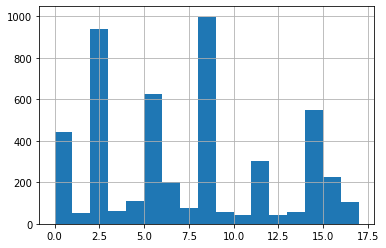

In [121]:
data.target.hist(bins=17)

In [122]:
mean_carr = np.mean(data.seq.progress_apply(len))
std_carr = np.std(data.seq.progress_apply(len))
print(mean_carr)
print("mean", mean_carr, "and std is", std_carr)

  0%|          | 0/4888 [00:00<?, ?it/s]

  0%|          | 0/4888 [00:00<?, ?it/s]

258.14279869067104
mean 258.14279869067104 and std is 162.24346887570542


We notice that the target isn't balanced, so we will take that into consideration by :
- adding sample weight in logistic regression and the other models that supports weight to impact directly the loss function
- we can make an oversampling using duplication which is poor or using smote (that add some guassian noise )
- we can make an undersampling by reducing the number of majority class samples

### Important functions 

In [123]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x


softmax_vect = np.vectorize(softmax)

In [124]:
# weighted multi-class log loss
from sklearn.metrics import log_loss


def weighted_mc_log_loss(y_true, y_pred, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    accuracy = round((y_true == y_pred).sum() / len(y_true) * 100, 2)
    return print(f"{loss = } and accuracy {accuracy = }")

In [125]:
def submit(y_pred_proba):
    # Write predictions to a file
    with open("sample_submission.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        lst = list()
        for i in range(18):
            lst.append("class" + str(i))
        lst.insert(0, "name")
        writer.writerow(lst)
        for i, protein in enumerate(proteins_test):
            lst = y_pred_proba[i, :].tolist()
            lst.insert(0, protein)
            writer.writerow(lst)

### Split data

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data,  # Features
    data.target.to_numpy(),  # Target variable
    test_size=0.2,  # 20% test size
)
X_train = X_train.reset_index(drop=True)  # we reste the indexes
X_test = X_test.reset_index(drop=True)

## Tf-idf

In [127]:
# Map sequences to
vec = TfidfVectorizer(analyzer="char", ngram_range=(1, 3))
X_train_tf = vec.fit_transform(X_train.seq)
X_test_tf = vec.transform(X_test.seq)
X_unseen = vec.transform(unseen.seq)
X_train_tf.shape

(3910, 8456)

In [128]:
# get the weight of each class
(unique, counts) = np.unique(y_train, return_counts=True)
class_weight = {uni: len(y_train) / count for uni, count in zip(unique, counts)}
# class_weight

### Logistic regression

In [14]:
# Setting up the model class
lr_model_tf = LogisticRegression(class_weight=class_weight, solver="liblinear")

# Training the model
lr_model_tf.fit(X_train_tf, y_train)

LogisticRegression(class_weight={0: 11.014084507042254, 1: 95.36585365853658,
                                 2: 5.3125, 3: 73.77358490566037,
                                 4: 41.59574468085106, 5: 7.7272727272727275,
                                 6: 23.987730061349694, 7: 64.09836065573771,
                                 8: 4.955640050697085, 9: 85.0,
                                 10: 118.48484848484848, 11: 15.959183673469388,
                                 12: 102.89473684210526, 13: 85.0,
                                 14: 8.826185101580135, 15: 21.96629213483146,
                                 16: 83.19148936170212,
                                 17: 108.61111111111111},
                   solver='liblinear')

In [15]:
## Calculate key performance metrics
test_pred_lr_proba = lr_model_tf.predict_proba(X_test_tf)
test_pred_lr = lr_model_tf.predict(X_test_tf)

# Print a classification report
print(
    classification_report(y_test, test_pred_lr)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       0.78      0.73      0.75        85
           1       1.00      0.22      0.36         9
           2       0.53      0.67      0.59       203
           3       0.71      0.71      0.71         7
           4       0.90      0.50      0.64        18
           5       0.49      0.72      0.58       119
           6       0.83      0.62      0.71        39
           7       0.50      0.08      0.13        13
           8       0.73      0.75      0.74       209
           9       0.25      0.09      0.13        11
          10       1.00      0.30      0.46        10
          11       0.47      0.47      0.47        60
          12       0.50      0.17      0.25         6
          13       0.86      0.46      0.60        13
          14       0.58      0.55      0.57       105
          15       0.60      0.25      0.35        48
          16       1.00      0.08      0.14        13
          17       1.00    

In [16]:
lr_model_tf.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [17]:
weighted_mc_log_loss(y_test, test_pred_lr, test_pred_lr_proba)

loss = 1.7718605251022106 and accuracy accuracy = 60.74


### multinomial NB

In [19]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tf, y_train)

test_pred_nb_proba = nb.predict_proba(X_test_tf)
test_pred_nb = nb.predict(X_test_tf)

# Print a classification report
print(
    classification_report(y_test, test_pred_nb)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       1.00      0.12      0.21        85
           1       0.00      0.00      0.00         9
           2       0.29      0.94      0.44       203
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        18
           5       0.81      0.11      0.19       119
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        13
           8       0.53      0.73      0.61       209
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        60
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        13
          14       1.00      0.01      0.02       105
          15       0.00      0.00      0.00        48
          16       0.00      0.00      0.00        13
          17       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
weighted_mc_log_loss(y_test, test_pred_nb, test_pred_nb_proba)

loss = 2.81454542950609 and accuracy accuracy = 37.42


### SVC

In [132]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc_init = LinearSVC(class_weight=class_weight)
svc = CalibratedClassifierCV(svc_init)
svc.fit(X_train_tf, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(class_weight={0: 11.5,
                                                              1: 95.36585365853658,
                                                              2: 5.234270414993307,
                                                              3: 81.45833333333333,
                                                              4: 39.89795918367347,
                                                              5: 7.696850393700787,
                                                              6: 23.841463414634145,
                                                              7: 64.09836065573771,
                                                              8: 4.845105328376704,
                                                              9: 95.36585365853658,
                                                              10: 111.71428571428571,
                                                              11: 16.70940170940171,
                                                              12: 105.67567567567568,
                                                              13: 88.86363636363636,
                                                              14: 8.846153846153847,
                                                              15: 21.483516483516482,
                                                              16: 79.79591836734694,
                                                              17: 122.1875}))

In [133]:
test_pred_svc_proba = svc.predict_proba(X_test_tf)
test_pred_svc = svc.predict(X_test_tf)

# Print a classification report
print(
    classification_report(y_test, test_pred_svc)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       100
           1       1.00      0.22      0.36         9
           2       0.57      0.77      0.65       192
           3       1.00      0.42      0.59        12
           4       1.00      0.50      0.67        14
           5       0.51      0.68      0.58       117
           6       0.79      0.58      0.67        38
           7       1.00      0.08      0.14        13
           8       0.62      0.73      0.67       191
           9       1.00      0.25      0.40        16
          10       1.00      0.25      0.40         8
          11       0.78      0.61      0.68        71
          12       1.00      0.29      0.44         7
          13       1.00      0.53      0.70        15
          14       0.57      0.58      0.58       106
          15       0.77      0.23      0.35        44
          16       1.00      0.36      0.53        11
          17       1.00    

In [134]:
weighted_mc_log_loss(y_test, test_pred_svc, test_pred_svc_proba)

loss = 1.3571869320423866 and accuracy accuracy = 62.78


In [28]:
submit(svc.predict_proba(X_unseen))

## Fasttext

In [89]:
# !wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
# !unzip v0.9.2.zip


# # # # if zip is already downloaded
# %cd fastText-0.9.2
# # for command line tool :
# !make
# # for python bindings :
# !pip install .

# %cd ..
# clear_output()

In [29]:
import fasttext
import csv


# inverseEncodingFastext is mainly to inverse the encoding of the prediction from __label_X to X
def inverseEncodingFastext(text):
    return int(re.sub("__label__", "", str(text)))  # replace __label__ by nothing


inverseEncodingFastext_vet = np.vectorize(inverseEncodingFastext)

In [30]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

oversample = RandomOverSampler(sampling_strategy={k: max(counts) for k in unique})
X_over, y_over = oversample.fit_resample(X_train, y_train)
print(Counter(y_over))

Counter({0: 789, 8: 789, 17: 789, 14: 789, 2: 789, 4: 789, 5: 789, 11: 789, 3: 789, 10: 789, 6: 789, 15: 789, 13: 789, 1: 789, 12: 789, 16: 789, 7: 789, 9: 789})


In [31]:
# define and store fasttext initial data as the library requires
def labelFastText(dataframe, target, outputName, predictor="seq"):
    df = dataframe.copy()
    df["target"] = target.copy()
    df["fastText"] = df["target"].progress_apply(lambda x: "__label__" + str(x))
    df = df.dropna(subset=[predictor, "target"])
    df = df.reset_index(drop=True)  # reset index
    df[predictor] = df[predictor].progress_apply(lambda x: " ".join(list(x)))
    df[["fastText", predictor]].to_csv(
        (outputName + ".txt"),
        index=False,
        sep=" ",
        header=None,
        quoting=csv.QUOTE_NONE,
        quotechar="",
        escapechar=" ",
    )
    return df

In [32]:
train = labelFastText(X_over, y_over, "train")
test = labelFastText(X_test, y_test, "test")

  0%|          | 0/14202 [00:00<?, ?it/s]

  0%|          | 0/14202 [00:00<?, ?it/s]

  0%|          | 0/978 [00:00<?, ?it/s]

  0%|          | 0/978 [00:00<?, ?it/s]

In [33]:
# we train our model
model_fasttext = fasttext.train_supervised(
    "train.txt",
    wordNgrams=6,  # n word grams are two
    # minn=1,
    # maxn=5,  # subwords max of  3 characters
    dim=100,  # dimension of embeeding vector or the hidden layer
    epoch=50,
    loss="softmax",  #
)

Read 3M words
Number of words:  22
Number of labels: 18
Progress: 100.0% words/sec/thread:  192030 lr:  0.000000 avg.loss:  1.213633 ETA:   0h 0m 0s  0.3% words/sec/thread:  233947 lr:  0.099737 avg.loss:  2.906124 ETA:   0h 1m54s  7.7% words/sec/thread:  200128 lr:  0.092259 avg.loss:  2.765759 ETA:   0h 2m 3s


In [95]:
# model_fasttext.save_model("model_fastext.bin")  # saving model
# model_fasttext=fasttext.load_model('model_fastext.bin') # loading model

In [35]:
results = model_fasttext.test("test.txt")
print(f"testing results for nature de prob are :{results}")

testing results for nature de prob are :(978, 0.5102249488752556, 0.5102249488752556)


In [36]:
def predict_fasttext(text, model):
    prediction = model.predict(str(text))  # get the prediction of the model
    # return inverseEncodingFastext(prediction[0][0]) # getting prediction directly with 0.5 threshold
    return inverseEncodingFastext(prediction[0][0])


def predict_fasttext_proba(text, model):
    prediction = model.predict(str(text), k=18)  # get the prediction of the model
    prediction[1][0] = 0.999
    arr = np.asarray(prediction[0])
    ind = inverseEncodingFastext_vet(arr)
    ind = ind.argsort()

    return prediction[1][ind]

In [37]:
pred = model_fasttext.predict(X_test.seq[2], k=18)
pred[1]

array([9.9364e-01, 6.3760e-03, 1.0000e-05, 1.0000e-05, 1.0000e-05,
       1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
       1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
       1.0000e-05, 1.0000e-05, 1.0000e-05])

In [45]:
test_pred_fasttext = test.seq.progress_apply(
    lambda sent: predict_fasttext(sent, model_fasttext)
).to_numpy()
test_pred_fasttext_proba = np.stack(
    test.seq.progress_apply(lambda sent: predict_fasttext_proba(sent, model_fasttext))
)

  0%|          | 0/978 [00:00<?, ?it/s]

  0%|          | 0/978 [00:00<?, ?it/s]

In [46]:
set(list(test_pred_fasttext))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17}

In [47]:
print(
    classification_report(y_test, test_pred_fasttext)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       0.63      0.64      0.63        85
           1       0.33      0.22      0.27         9
           2       0.55      0.44      0.49       203
           3       0.43      0.43      0.43         7
           4       0.75      0.50      0.60        18
           5       0.48      0.61      0.54       119
           6       0.49      0.64      0.56        39
           7       0.13      0.15      0.14        13
           8       0.69      0.61      0.64       209
           9       0.00      0.00      0.00        11
          10       0.75      0.30      0.43        10
          11       0.43      0.48      0.46        60
          12       0.50      0.17      0.25         6
          13       0.88      0.54      0.67        13
          14       0.41      0.55      0.47       105
          15       0.18      0.25      0.21        48
          16       0.11      0.08      0.09        13
          17       1.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
weighted_mc_log_loss(
    y_test,
    test_pred_fasttext,
    test_pred_fasttext_proba,
)

loss = 1.7077549265761964 and accuracy accuracy = 51.02


#### fatstext embeeding plus some other models

In [49]:
import fasttext
from sklearn.decomposition import PCA

from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

fasttextModel = fasttext.load_model("model_fastext.bin")  # 17000 item /sec


def filterXY(X, y, indexes):
    X = X[indexes]
    y = y[indexes]
    return X, y


class Classification:
    """Home made classification with and pycaret"""

    def __init__(self, X, y, vecW="fasttext"):
        self.X_ = X
        self.y_ = y
        self.vecW_ = vecW
        self.classesCountStart_ = Counter(self.y_)

        print("- " * 40)
        print(f"Classes are {self.classesCountStart_}")
        print("- " * 40)

    def sent2vec_(self, text):
        if self.vecW_ == "fasttext":
            return fasttextModel.get_sentence_vector(text)

    def fit(self, verbose=False):
        self.Xtok_, self.ytok_ = filterXY(
            self.X_, self.y_, self.X_.notna()
        )  # filter from nan values
        print("- " * 40)
        print("starting sent2vec ...")
        self.Xtok_ = self.X_.progress_apply(self.sent2vec_)
        print(" sent2vec done :)")
        print("- " * 40)
        if verbose:
            return self.Xtok_

    def transform(self, verbose=False):
        print("transformation from 1D to nD is done")
        self.Xtransformed_, self.Ytransformed_ = filterXY(
            self.Xtok_, self.ytok_, self.Xtok_.notna()
        )
        self.Xtransformed_ = np.stack(self.Xtransformed_)
        print("- " * 40)
        if verbose:
            return self.Xtransformed_

    def fitPca(self, n_components=100, verbose=True, pca=None):
        if not pca:
            self.pca_ = PCA(n_components=n_components)
            self.pca_.fit(self.Xtransformed_)
        else:
            print("old pca taken into consideration")
            self.pca_ = pca
        if verbose:
            print("the total ratio of explained variance is :")
            print(np.sum(self.pca_.explained_variance_ratio_))
            print("the cummulative sum of explained variance is :")
            print(np.cumsum(self.pca_.explained_variance_ratio_))
        print("- " * 40)
        return self.pca_

    def balance(self, algo="adasyn"):
        print("Banalancing data is starting  ...")
        if algo == "adasyn":
            self.Xtransformed_, self.Ytransformed_ = ADASYN(
                n_jobs=-1, sampling_strategy={k: max(counts) for k in unique}
            ).fit_resample(self.Xtransformed_, self.Ytransformed_)

        elif algo == "smote":
            self.Xtransformed_, self.Ytransformed_ = SMOTE(n_jobs=-1).fit_resample(
                self.Xtransformed_, self.Ytransformed_
            )

        print("Banalancing data with " + algo + "is Done :)")

    def todataFrame(self, withPca=False):
        # raise DeprecationWarning('to use pca you should call the function .fitPca, then assign True to withPca args')
        self.df_ = self.Xtransformed_
        if withPca and self.pca_:
            self.df_ = self.pca_.transform(self.df_)
        self.df_ = pd.DataFrame(self.df_)
        self.df_["label_orig"] = self.Ytransformed_
        print("- " * 40)
        print(f"shape of dataframe is {self.df_.shape}")
        self.classesCountEnd_ = Counter(self.df_["label_orig"])
        print(f"Classes in the end are {self.classesCountEnd_}")
        return self.df_

In [50]:
clf = Classification(X_train.seq, y_train, vecW="fasttext")
clf.fit()
clf.transform()
clf.balance(algo="smote")
# pca = clf.fitPca(
#     n_components=30, verbose=True
# )  # if you comment this you should comment [ to be commented 1]
X_train_embed = clf.todataFrame(
    # withPca=True
)  # [ to be commented 1]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Classes are Counter({8: 789, 2: 736, 5: 506, 14: 443, 0: 355, 11: 245, 15: 178, 6: 163, 4: 94, 7: 61, 3: 53, 16: 47, 13: 46, 9: 46, 1: 41, 12: 38, 17: 36, 10: 33})
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
starting sent2vec ...


  0%|          | 0/3910 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


 sent2vec done :)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
transformation from 1D to nD is done
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Banalancing data is starting  ...
Banalancing data with smoteis Done :)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
shape of dataframe is (14202, 101)
Classes in the end are Counter({0: 789, 8: 789, 17: 789, 14: 789, 2: 789, 4: 789, 5: 789, 11: 789, 3: 789, 10: 789, 6: 789, 15: 789, 13: 789, 1: 789, 12: 789, 16: 789, 7: 789, 9: 789})


In [51]:
clf_unseen = Classification(X_test.seq, y_test, vecW="fasttext")
clf_unseen.fit()
clf_unseen.transform()
# clf_unseen.fitPca(pca=pca)

X_test_embed = clf_unseen.todataFrame(
    # withPca=True
)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Classes are Counter({8: 209, 2: 203, 5: 119, 14: 105, 0: 85, 11: 60, 15: 48, 6: 39, 4: 18, 16: 13, 13: 13, 7: 13, 9: 11, 17: 10, 10: 10, 1: 9, 3: 7, 12: 6})
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
starting sent2vec ...


  0%|          | 0/978 [00:00<?, ?it/s]

 sent2vec done :)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
transformation from 1D to nD is done
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
shape of dataframe is (978, 101)
Classes in the end are Counter({8: 209, 2: 203, 5: 119, 14: 105, 0: 85, 11: 60, 15: 48, 6: 39, 4: 18, 16: 13, 13: 13, 7: 13, 9: 11, 17: 10, 10: 10, 1: 9, 3: 7, 12: 6})


In [52]:
# X_train_embed = pd.read_csv("X_train_embed.csv", index_col=0)
y_train_embed = X_train_embed["label_orig"]
X_train_embed = X_train_embed[X_train_embed.columns.difference(["label_orig"])]
# X_test_embed = pd.read_csv("X_test_embed.csv", index_col=0)
y_test_embed = X_test_embed["label_orig"]
X_test_embed = X_test_embed[X_test_embed.columns.difference(["label_orig"])]

In [53]:
# !pip install catboost
# !pip install xgboost
# !pip install lazypredict
!pip install lightgbm
clear_output()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:0000:0100:01


NameError: name 'clear_output' is not defined

In [ ]:
# import lazypredict
# from lazypredict.Supervised import LazyClassifier
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split

# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train_embed, X_test_embed, y_train_embed, y_test_embed)

# print(models)

In [55]:
# build the lightgbm model
import lightgbm as lgb

clf_lgb = lgb.LGBMClassifier()
clf_lgb.fit(X_train_embed, y_train_embed)

LGBMClassifier()

In [58]:
test_pred_lbg_proba = clf_lgb.predict_proba(X_test_embed)
test_pred_lbg = clf_lgb.predict(X_test_embed)

# Print a classification report
print(
    classification_report(y_test, test_pred_lbg)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       0.11      0.07      0.09        85
           1       0.00      0.00      0.00         9
           2       0.25      0.26      0.25       203
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        18
           5       0.14      0.14      0.14       119
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        13
           8       0.20      0.26      0.23       209
           9       0.00      0.00      0.00        11
          10       0.02      0.20      0.03        10
          11       0.14      0.07      0.09        60
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        13
          14       0.10      0.09      0.09       105
          15       0.00      0.00      0.00        48
          16       0.00      0.00      0.00        13
          17       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
weighted_mc_log_loss(y_test, test_pred_lbg, test_pred_lbg_proba)

loss = 2.883280706220185 and accuracy accuracy = 14.93
